In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers, Model, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Flatten

from tensorflow.python.keras import utils
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint


np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Checking the installed version of TensorFlow and Keras.

print(tf.__version__)
print(keras.__version__)

2.9.2
2.9.0


In [ ]:
# Testing GPU to make sure that it is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi -L

SystemError: ignored

In [4]:
# Unzipping combined_dataset

combined_faces_zip_path = "/content/drive/My Drive/AE/Datasets/combined_dataset.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('unzipping combined_dataset.zip is done!')

unzipping combined_dataset.zip is done!


In [5]:
# Unzipping combined_augmented_dataset 

combined_faces_zip_path = "/content/drive/My Drive/AE/Datasets/combined_augmented_dataset.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('unzipping combined_augmented_dataset.zip is done!')

unzipping combined_augmented_dataset.zip is done!


## Building CNN Model

In [6]:
# Reading the filenames of images from Training, validation, and testing datasets in order to create tensors of images.
train_aug_df = pd.read_csv(r"/content/drive/My Drive/AE/Case-III/IO/filenames_age_target_train_augmented.csv")
valid_df = pd.read_csv(r"/content/drive/My Drive/AE/Case-III/IO/filenames_age_target_valid.csv")
test_df = pd.read_csv(r"/content/drive/My Drive/AE/Case-III/IO/filenames_age_target_test.csv")

In [7]:
train_aug_df.shape

(234400, 3)

In [8]:
valid_df.shape

(7534, 3)

In [9]:
test_df.shape

(2512, 3)

In [10]:
train_aug_df.head()

,filename,age,target
0,/content/combined_augmented_dataset/43_77_rot_...,43,5
1,/content/combined_augmented_dataset/71_50_flip...,71,7
2,/content/combined_augmented_dataset/6_51_flipl...,6,1
3,/content/combined_augmented_dataset/18_301_fli...,18,3
4,/content/combined_augmented_dataset/25_686_rot...,25,4


In [11]:
valid_df.head()

,filename,age,target
0,/content/combined_dataset/26_2270.jpg,26,4
1,/content/combined_dataset/54_18.jpg,54,6
2,/content/combined_dataset/33_16.jpg,33,5
3,/content/combined_dataset/29_159.jpg,29,5
4,/content/combined_dataset/72_57.jpg,72,7


In [12]:
test_df.head()

,filename,age,target
0,/content/combined_dataset/25_358.jpg,25,4
1,/content/combined_dataset/24_593.jpg,24,4
2,/content/combined_dataset/24_687.jpg,24,4
3,/content/combined_dataset/1_946.jpg,1,0
4,/content/combined_dataset/4_269.jpg,4,1


In [13]:
train_aug_df['target'].value_counts(normalize=True)

5    0.279394
4    0.199829
6    0.167193
0    0.095307
7    0.080546
3    0.060922
1    0.059812
2    0.056997
Name: target, dtype: float64

In [14]:
valid_df['target'].value_counts(normalize=True)

5    0.279400
4    0.199761
6    0.167109
0    0.095301
7    0.080568
3    0.060791
1    0.059995
2    0.057075
Name: target, dtype: float64

In [15]:
test_df['target'].value_counts(normalize=True)

5    0.279459
4    0.199841
6    0.167197
0    0.095541
7    0.080414
3    0.060908
1    0.059713
2    0.056927
Name: target, dtype: float64

In [16]:
# taking the filenames and target labels and converting them to list in order to create tensors.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

valid_filenames_list = list(valid_df['filename'])
valid_labels_list = list(valid_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [17]:
# Creating fixed tensorflow tesnsors.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

valid_filenames_tensor = tf.constant(valid_filenames_list)
valid_labels_tensor = tf.constant(valid_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [18]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels parameter in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 8

def _reading_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=0 --> no changes, channels=1 --> grayscale, channels=3 --> RGB.
    image_resized = tf.image.resize(image_decoded, [50, 50])
    image_normlized = tf.cast(image_resized, tf.float32)/ 255.
    
    label = tf.one_hot(label, num_classes)

    return image_normlized, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
Batch_size = 50

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_reading_function)
train_aug_dataset = train_aug_dataset.batch(Batch_size)    

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_filenames_tensor, valid_labels_tensor))
valid_dataset = valid_dataset.map(_reading_function)
valid_dataset = valid_dataset.batch(Batch_size)   

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_reading_function)
test_dataset = test_dataset.batch(Batch_size)    

In [ ]:
# create the exact same model used in training process, including its weights and the optimizer
final_cnn = load_model(r"/content/drive/My Drive/AE/Case-III/IO/final_cnn_model_afterTraining_acc_0.892.h5")

final_cnn.summary()

Model: "Age_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 50, 50, 32)        320       
                                                                 
 BatchNormalization_1 (Batch  (None, 50, 50, 32)       200       
 Normalization)                                                  
                                                                 
 Conv2D_11 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 BatchNormalization_11 (Batc  (None, 50, 50, 32)       200       
 hNormalization)                                                 
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 25, 25, 32)       0 

In [ ]:
# Evaluating the model on test dataset.

final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

51/51 [==============================] - 25s 445ms/step - loss: 0.9426 - accuracy: 0.8639


In [ ]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 4)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 4)}')

CNN model loss 		= 0.9426
CNN model accuracy 	= 0.8639


In [ ]:
# Generating predictions from the model above.

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)
print(final_cnn_pred)

51/51 [==============================] - 19s 374ms/step
[4 4 4 ... 5 4 5]


In [ ]:
len(final_cnn_pred)

2512

In [ ]:
len(test_labels_list)

2512

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[236,   4,   0,   0,   0,   0,   0,   0],
       [  6, 137,   2,   1,   1,   1,   2,   0],
       [  1,   7, 123,  11,   0,   1,   0,   0],
       [  1,   0,   1, 140,   6,   4,   1,   0],
       [  0,   1,   5,  28, 420,  43,   4,   1],
       [  0,   0,   3,  14,  84, 567,  33,   1],
       [  0,   0,   2,   0,   4,  27, 372,  15],
       [  0,   1,   0,   0,   0,   2,  24, 175]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.rcParams.update({'font.size':18})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=20)
    plt.xlabel('Predicted labels', fontsize=20)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/AE/Case-III/Plots/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


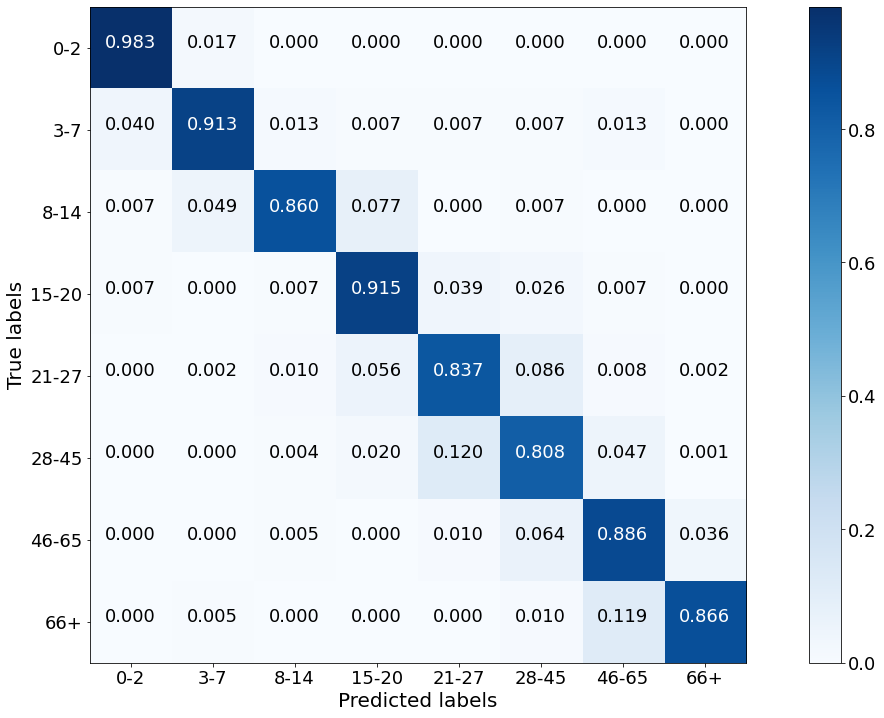

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['0-2', '3-7', '8-14', '15-20', '21-27', '28-45', '46-65', '66+']

plt.figure(figsize=(18,10))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


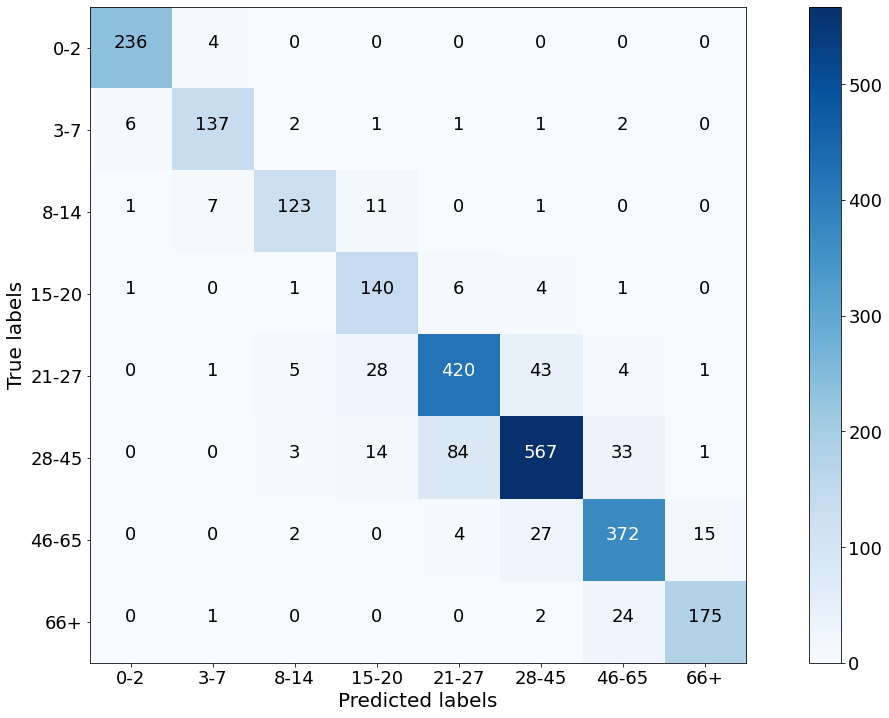

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['0-2', '3-7', '8-14', '15-20', '21-27', '28-45', '46-65', '66+']

plt.figure(figsize=(18,10))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat"
                     )

plt.show()

In [ ]:
# Calculating the other metrics on testing dataset.

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels_list, final_cnn_pred, target_names = cm_plot_labels, digits = 4)) 

              precision    recall  f1-score   support

         0-2     0.9672    0.9833    0.9752       240
         3-7     0.9133    0.9133    0.9133       150
        8-14     0.9044    0.8601    0.8817       143
       15-20     0.7216    0.9150    0.8069       153
       21-27     0.8155    0.8367    0.8260       502
       28-45     0.8791    0.8077    0.8419       702
       46-65     0.8532    0.8857    0.8692       420
         66+     0.9115    0.8663    0.8883       202

    accuracy                         0.8639      2512
   macro avg     0.8707    0.8835    0.8753      2512
weighted avg     0.8670    0.8639    0.8641      2512

